# Flor

Lorem Ipsum

![object model](./object_model.png)
<center><i>Artifacts in rectangles; Literals in underline; Actions in circles</i></center>

Lorem Ipsum

## Prepare your environment before starting the activities.

We're going to start by importing Flor and letting it know the name of our notebook.

In [1]:
# Import Flor
import flor

# If the notebook name has not already been set, you are able to set the name in code. 
flor.setNotebookName('tutorial.ipynb')

## Sentiment Analaysis

First, we'll go through a short exercise to illustrate a common interactive model-training pattern. Here, we hope to demonstrate the value of versioning and provenance to motivate Flor. 

Let's get started. We're going to train a model to predict the sentiment polarity (positive, or negative) of English phrases. The model-training pipeline is fairly standard: we load a dataset, do some light preprocessing, do a train/test split, train the model, and then validate. 

In [ ]:
# Import standard libraries
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Load the Data
movie_reviews = pd.read_json('data.json')

# Do light preprocessing
movie_reviews['rating'] = movie_reviews['rating'].map(lambda x: 0 if x < 5 else 1)

# Do train/test split
X_tr, X_te, y_tr, y_te = train_test_split(movie_reviews['text'], movie_reviews['rating'], 
                                          test_size=0.20, random_state=92)

# Vectorize the English sentences
vectorizer = TfidfVectorizer()
vectorizer.fit(X_tr)
X_tr = vectorizer.transform(X_tr)
X_te = vectorizer.transform(X_te)

# Fit the model              ##############
clf = RandomForestClassifier(n_estimators=5).fit(X_tr, y_tr)
                             ##############
y_pred = clf.predict(X_te)

# Validate the predictions
c = classification_report(y_te, y_pred)

print(c)

We see a report above. The precision and recall are hovering around 70%. From reading the code block, we also noticed that the Random Forest classifier was trained on just **5 estimators**, let's see what happens if we **increase the number of estimators to 7**.

In [ ]:
# Fit a new model            ###############
clf2 = RandomForestClassifier(n_estimators=7).fit(X_tr, y_tr)
                             ###############
y_pred = clf2.predict(X_te)

# Validate the predictions
score = clf2.score(X_te, y_te)
c = classification_report(y_te, y_pred)

print(c)

We see a minor improvement.

### Sentiment Analysis: Discussion

In the exercise we just completed, we enforced some rudimentary forms of versioning and provenance. For versioning, rather than over-writing our model-fitting cell, we created a new cell, and rather than overwriting the `clf` variable, we created a new `clf2` variable. Moreover, if we save and version this notebook in a version control system such as Git, we might be able to restore the current version of this notebook, and fit a very similar model to the one we wanted. Given these practices, if we break something, we can rollback. As for provenance, the plaintext accompanying the cells (as well as the in-line comments) will allow a human to interpret causal effects: the only thing we changed was the number of estimators, and we changed the number of estimators from 5 to 7, which improved the quality metrics of the model. This human analyst would be able to answer questions such as, what data did you read, and where did you read it from? And, what model did you fit?

Despite some of these benefits, this rudimentary form of versioning and provenance tracking doesn't scale well. An analyst rushing to meet a deadline may over-write the same cell rather than make a copy, or forget to commit to Git after any change to the notebook: this would compromise our quality of versioning. Moreover, it's easy to see that as the complexity of the model-training pipeline increases from a few dozen lines of code to the thousands, and the model-training pipeline involves some distribution of code and data, and use of heterogeneous and complex infrastructure, manual human inspection of source code will be an inadequate substitute for a provenance management system. 

## Sentiment Analysis in Flor

Flor is a context-first system for managing the pipeline development phase of the ML Lifecycle. Two of the many useful things Flor supports is automatic versioning of experiments and provenance tracking. We'll start by showing these two features of Flor, while emphasizing how little effort it takes to wrap a pre-existing pipeline (namely, the one we ran before) in Flor. Here, we hope to convince you that you would rather use Flor than implement versioning and provenance tracking yourself.

### BEGIN FLOR EXPERIMENT

In the cell below, we've copied the model-training pipeline (with 5 estimators). We highlight the differences in-line using `###`.

             precision    recall  f1-score   support

          0       0.73      0.72      0.72      5024
          1       0.72      0.73      0.72      4976

avg / total       0.72      0.72      0.72     10000



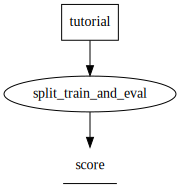

In [4]:
###################################
@flor.track_action('risecamp_demo')
def split_train_and_eval(**kwargs):
###################################
    import pandas as pd

    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import classification_report
    movie_reviews = pd.read_json('data.json')
    movie_reviews['rating'] = movie_reviews['rating'].map(lambda x: 0 if x < 5 else 1)

    X_tr, X_te, y_tr, y_te = train_test_split(movie_reviews['text'], movie_reviews['rating'], 
                                              test_size=0.20, random_state=92)

    vectorizer = TfidfVectorizer()
    vectorizer.fit(X_tr)
    X_tr = vectorizer.transform(X_tr)
    X_te = vectorizer.transform(X_te)
    clf = RandomForestClassifier(n_estimators=7).fit(X_tr, y_tr)
    
    y_pred = clf.predict(X_te)

    score = clf.score(X_te, y_te)
    c = classification_report(y_te, y_pred)

    print(c)
    
    #######################
    return {'score': score}
    #######################
split_train_and_eval()

In [3]:
flor.Experiment('risecamp_demo').summarize()

,utag,score,tutorial
0,2018-10-07_06-47-15,0.7038,tutorial_139778414760736.ipynb


We had to make 2 changes to wrap our model-training pipeline in Flor:
1. Copy and paste the code into a decorated function
2. Return the value we want Flor to track

Next, we declare an experiment that uses our pipeline:

Here, we see the dataflow graph of the our `risecamp_demo` experiment. We read it as follows: the function `split_train_and_eval` defined in the tutorial artifact (`tutorial.ipynb`) is run to produce a `score` value. Despite its simplicity and coarse granularity, this is a provenance graph for the `score`.

So far, we've only defined the computation. Let's run the code to train the model and produce a score.

As before, and as expected, we see that the score is hovering around 70%.

***Important instructions*** Now, you will jump to **BEGIN FLOR EXPERIMENT** (scroll up), and modify the cell underneath that label. Change the number of estimators from 5 to 7 (Line 21). Re-run every cell underneath, then come back here and run the cells below.

[NOTE THIS IS FIRST TIME THEY SEE DF] But we also see that our Jupyter notebook was automatically versioned (see the cell in the `tutorial` columns), and all of the relevant artifacts were associated with the execution name `first_pull`. 

Here, you should see that what would have been a destructive change without Flor (over-writing a cell and re-running it), is properly handled with Flor. Flor automatically preserves versions and tracks provenance.

## Finer granularity tracking in Flor

             precision    recall  f1-score   support

          0       0.73      0.73      0.73      5024
          1       0.73      0.73      0.73      4976

avg / total       0.73      0.73      0.73     10000

             precision    recall  f1-score   support

          0       0.72      0.71      0.72      5024
          1       0.71      0.72      0.72      4976

avg / total       0.72      0.72      0.72     10000



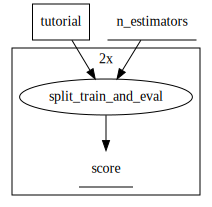

In [5]:
###################################
@flor.track_action('risecamp_demo')
def split_train_and_eval(n_estimators, **kwargs):
###################################
    import pandas as pd

    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import classification_report
    movie_reviews = pd.read_json('data.json')
    movie_reviews['rating'] = movie_reviews['rating'].map(lambda x: 0 if x < 5 else 1)

    X_tr, X_te, y_tr, y_te = train_test_split(movie_reviews['text'], movie_reviews['rating'], 
                                              test_size=0.20, random_state=92)

    vectorizer = TfidfVectorizer()
    vectorizer.fit(X_tr)
    X_tr = vectorizer.transform(X_tr)
    X_te = vectorizer.transform(X_te)
    clf = RandomForestClassifier(n_estimators=n_estimators).fit(X_tr, y_tr)
    
    y_pred = clf.predict(X_te)

    score = clf.score(X_te, y_te)
    c = classification_report(y_te, y_pred)

    print(c)
    
    #######################
    return {'score': score}
    #######################
    
split_train_and_eval([5, 7])

In [6]:
flor.Experiment('risecamp_demo').summarize()

,utag,score,n_estimators,tutorial
0,2018-10-07_06-54-28,0.7154,5.0,tutorial_139779114592072.ipynb
1,2018-10-07_06-54-28,0.7327,7.0,tutorial_139779114592072.ipynb
2,2018-10-07_06-51-41,0.7214,NaN,tutorial_139779312639224.ipynb
3,2018-10-07_06-47-15,0.7038,NaN,tutorial_139778414760736.ipynb


## Interpreting someone else's work in Flor

In this next exercise, as in many "real-world" cases, you'll be joining an in-progress model development effort. Bob, a fellow member of your team, has already attempted two different data-preprocessing steps.

Run the cell below but notice that we are using a different experiment name (`bob_preproc` rather than `risecamp_demo`). Here, we are going to summarize someone else's past experiment versions.

In [ ]:
flor.Experiment('bob_preproc').summarize()

Let's interpret the output. The first column, `utag`, lists the different versions of the experiment by name. We can see there are two past versions of the experiment `bob_preproc`: `first_preproc`, and `second_preproc`.  Now, let's pause for a second, run the next cell, and continue reading.

In [ ]:
flor.Experiment('bob_preproc').plot('first_preproc')

We can now see the structure of the dataflow graph. We see that there are four (4) artifacts: `preprocess`, `data_loc`, `intermediate_X`, and `intermediate_y`.

Next, we inspect the structure of the dataflow graph, for the second version:

In [ ]:
flor.Experiment('bob_preproc').plot('second_preproc')

We see that both node-link diagrams look the same. This means that the structure of the different experiment versions is the same; however, it is very likely that the contents of the computation graph differ. To see where the difference is, we `diff` the two versions of Bob's experiment.

In [ ]:
flor.Experiment('bob_preproc').diff('first_preproc', 'second_preproc')

We see that `preprocess.py` was modified, so Bob probably tried two different preprocessing techniques.

We can continue to audit Bob with Flor, and this would alone be an interesting and worthwhile activity, but for the purposes of this tutorial, we will start by _using_ the preprocessed data created by Bob, and inspect it only if we need to.

## Using someone else's work in Flor

Earlier we brought ourselves "up to speed" with the preprocessing work that our colleague Bob had undertaken. We will now use Bob's preprocessed data instead of preprocessing the data ourselves. Here, we will show you how two different users of Flor may share their experiments and the artifacts/derived or consumed therewith.

Here's a reminder of what the previous experiment versions look like:

In [ ]:
flor.Experiment('bob_preproc').summarize()

Below, we copy/pasted the pipeline you're already familiar with. As before, we highlight the changes in `###`.

In [ ]:
@flor.func              ##############  ##############  ############
def split_train_and_eval(intermediate_X, intermediate_y, n_estimators, **kwargs):
                        ##############  ##############  ############
    import pandas as pd
    import json

    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import classification_report
            
              ##############
    with open(intermediate_X) as json_data:
              ##############
        X = json.load(json_data)
        json_data.close()
        
              ##############
    with open(intermediate_y) as json_data:
              ##############
        y = json.load(json_data)
        json_data.close()

    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, random_state=92)

    vectorizer = TfidfVectorizer()
    vectorizer.fit(X_tr)
    X_tr = vectorizer.transform(X_tr)
    X_te = vectorizer.transform(X_te)
    
                                              ############
    clf = RandomForestClassifier(n_estimators=n_estimators).fit(X_tr, y_tr)
                                              ############
    
    y_pred = clf.predict(X_te)

    score = clf.score(X_te, y_te)
    print(score)
    
    return {'score': score}

In [ ]:
with flor.Experiment('bob_preproc') as ex:
    data_x = ex.artifact('data_clean_X.json', 'intermediate_X', utag="first_preproc")
    data_y = ex.artifact('data_clean_y.json', 'intermediate_y', utag="first_preproc")

with flor.Experiment('risecamp_demo') as ex:
    n_estimators = ex.literalForEach([5, 7], 'n_estimators')
    do_split_train_and_eval = ex.action(split_train_and_eval, [data_x, data_y, n_estimators])
    score = ex.literal(name='score', parent=do_split_train_and_eval)


Lorem Ipsum

In [ ]:
score.plot()

In [ ]:
#Run the experiment
score.pull('third_pull')

In [ ]:
flor.Experiment('risecamp_demo').summarize()

## Pull again, trying a different dataset

In [ ]:
flor.Experiment('bob_preproc').summarize()

In [ ]:
data_x.version = "second_preproc"
data_y.version = "second_preproc"

In [ ]:
score.plot()

In [ ]:
score.pull('fourth_pull')

In [ ]:
flor.Experiment('risecamp_demo').summarize()

## Of all the things we tried, what helped the most?

In [ ]:
summary = flor.Experiment('risecamp_demo').summarize()
summary

In [ ]:
summary.cube({'score': 'mean'})